# Version information

In [1]:
from datetime import date
print("Running date:", date.today().strftime("%B %d, %Y"))
import pyleecan
print("Pyleecan version:" + pyleecan.__version__)
import SciDataTool
print("SciDataTool version:" + SciDataTool.__version__)


Running date: July 11, 2022
Pyleecan version:1.3.9
SciDataTool version:2.4.8


# Force Module을 사용하여 자기력을 계산하는 방법

이 튜토리얼은 pyleecan으로 **자기력을 계산**하는 다양한 단계를 보여줍니다.

SciDataTool 개체의 기능과 사용법을 설명하기 위해 FEMM뮬레이션을 실행하고 전류를 인가하여 실행 시간을 줄이기 위해 주기성과 병렬연산을 사용합니다.

c:\Users\KDH2018-PC\anaconda3\envs\py38_pyleecan139\lib\site-packages\pyleecan\Methods\Machine\Machine\plot.py:187: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


0.00193

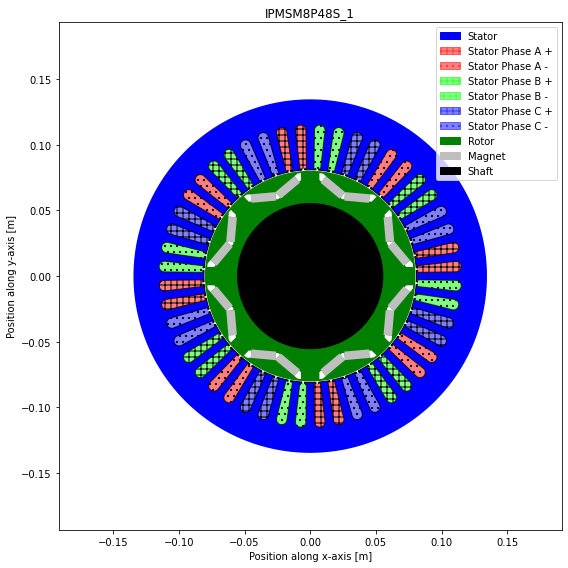

In [3]:
%matplotlib inline

# Load the machine
from os.path import join
from numpy import (
    zeros,
    exp,
    pi,
    real,
    meshgrid,
    mean,
)

# 힘 계산 클래스 추가
from pyleecan.Classes.ForceMT import ForceMT
from pyleecan.Classes.OPdq import OPdq
from pyleecan.Classes.Simu1 import Simu1
from pyleecan.Classes.MagFEMM import MagFEMM
from pyleecan.Classes.InputCurrent import InputCurrent
from pyleecan.definitions import DATA_DIR


from pyleecan.Functions.load import load
from pyleecan.Functions.Plot import dict_2D, dict_3D 

# print(DATA_DIR)

path = 'D:/NGV/Lecture_Simu_Model'
modelname = 'IPMSM8P48S1'
model = join(modelname+'.json')

# Load machine
Toyota_Prius = load(join(path,model))
Toyota_Prius.plot()
save_path='D:/NGV/result_parasweep'
Toyota_Prius.stator.slot.W0 #% [m] 

In [4]:
import numpy as np
from pyleecan.Classes.ImportMatrixVal import ImportMatrixVal
from pyleecan.Classes.InputCurrent import InputCurrent
from pyleecan.Classes.ImportGenVectLin import ImportGenVectLin
from pyleecan.Classes.ImportGenVectSin import ImportGenVectSin
from pyleecan.Classes.ImportGenMatrixSin import ImportGenMatrixSin
ref_simu = Simu1(name="test_slot_scale", machine=Toyota_Prius)

# # Definition of the enforced output of the electrical module
# Is_mat = zeros((1, 3))
# Is_mat[0, :] = np.array([0, 12.2474, -12.2474])
# Is = ImportMatrixVal(value=Is_mat)
# time = ImportGenVectLin(start=0, stop=0, num=1, endpoint=False)
# Na_tot = 2048

## Simu 1 Simulation (No-load)

In [5]:
from numpy import sqrt, pi
ref_simu.input = InputCurrent()
ref_simu.input.Nt_tot = 128 # Number of time step
ref_simu.input.Na_tot = 2048 # Spatial discretization
# Set reference simulation operating point
ref_simu.input.OP = OPdq(N0 = 2000) # Rotor speed [rpm]
ref_simu.input.OP.Tem_av_ref = 353
ref_simu.input.OP.set_I0_Phi0(I0=250/sqrt(2), Phi0=140*pi/180)


# Definition of the magnetic simulation
ref_simu.mag = MagFEMM(
    type_BH_stator=0,
    type_BH_rotor=0,
    is_periodicity_a=True,
    is_periodicity_t=True,
    Kgeo_fineness=0.2,
    Kmesh_fineness=0.2,
    nb_worker=8,
)
ref_simu.force=ForceMT(  is_periodicity_a=True,is_periodicity_t=True,)

In [6]:
# result=ref_simu.run()

In [7]:
# 접선방향 전체 파형 2D (Mech_order / wavenumber)
AGSF_load=Xout_sweep.force.AGSF
# mech_order - wavenumber
AGSF_load.plot_3D_Data(
    "freqs->mech_order=[0,96]",
    "wavenumber=[-96,96]",
    N_stem=100,
    is_2D_view=True,
#     **dict_3D
)

# # mech_order - space_order
# AGSF_load.plot_3D_Data(
#     "freqs->mech_order=[0,96]",
#     "wavenumber->space_order=[-25,25]",
#     N_stem=100,
#     is_2D_view=True,
#     **dict_3D
# )


NameError: name 'Xout_sweep' is not defined

In [8]:
from pyleecan.Classes.VarParam import VarParam
from pyleecan.Classes.ParamExplorerSet import ParamExplorerSet
from pyleecan.Classes.DataKeeper import DataKeeper
multisim = VarParam(
    stop_if_error=True,
    is_reuse_femm_file=False,
)
ref_simu.var_simu = multisim

In [9]:
from numpy import pi, ones, zeros, linspace
from pyleecan.Classes.ParamExplorerInterval import ParamExplorerInterval

# paramexplorer_list = [
#     ParamExplorerSet(
#         name="Stator slot scale factor",
#         symbol="stat_slot",
#         unit="",
#         setter=simu.machine.stator.slot.W0,
#         value=linspace(0.1, 1.1, 11).tolist(),
#     )
# ]

paramexplorer_list=[ParamExplorerInterval(
    name="Stator slot opening",
    symbol="W0s",
    unit="m",
    setter="simu.machine.stator.slot.W0",
    getter="simu.machine.stator.slot.W0",
    min_value=0.1 * Toyota_Prius.stator.slot.W0,
    max_value=1.4 * Toyota_Prius.stator.slot.W0,
    N=14,
)
]

TypeError: 'property' object is not callable

In [8]:
multisim.paramexplorer_list = paramexplorer_list
error_keeper_mag_flux = "lambda simu: np.nan * np.zeros(len(simu.mag.B.Time.get_values()), len(simu.mag.B.Angle.get_values()))"

## Simu2 simulation (Load) w parameter sweep & 2 OP point


In [256]:

# datakeeper_list = [
#     DataKeeper(
#         name="Average Torque",
#         unit="N.m",
#         symbol="Tem_av",
#         keeper="lambda output: output.mag.Tem_av",
#         error_keeper="lambda simu: np.nan",
#     ),
#     DataKeeper(
#         name="Radial Airgap flux density",
#         unit="H",
#         symbol="B",
#         keeper="lambda output: output.mag.B.components['radial'].get_along('time','angle')['B_{rad}']",
#         error_keeper=error_keeper_mag_flux,
#     ),
#     DataKeeper(
#         name="0th_6f Harmonic",
#         unit="N.m^2",
#         symbol="r06fs",
#         keeper="lambda output: output.force.AGSF.components['radial'].get_magnitude_along('freqs->elec_order=6','wavenumber=0')['AGSF_r']",
#         error_keeper="lambda simu: np.nan",
#     ),
#     DataKeeper(
#         name="0th_12f Harmonic",
#         unit="N.m^2",
#         symbol="r012fs",
#         keeper="lambda output: output.force.AGSF.components['radial'].get_magnitude_along('freqs->elec_order=12','wavenumber=0')['AGSF_r']",
#         error_keeper="lambda simu: np.nan",
#     ),
#     DataKeeper(
#         name="24th_6f Harmonic",
#         unit="N.m^2",
#         symbol="r24_6fs",
#         keeper="lambda output: output.force.AGSF.components['radial'].get_magnitude_along('freqs->mech_order=24','wavenumber=24')['AGSF_r']",
#         error_keeper="lambda simu: np.nan",
#     ),
#     DataKeeper(
#         name="n24th_6f Harmonic",
#         unit="N.m^2",
#         symbol="rn24_6fs",
#         keeper="lambda output: output.force.AGSF.components['radial'].get_magnitude_along('freqs->mech_order=24','wavenumber=-24')['AGSF_r']",
#         error_keeper="lambda simu: np.nan",
#     ),
#     DataKeeper(
#         name="stator Slot",
#         unit="",
#         symbol="W0s",
#         keeper="lambda output: output.simu.machine.stator.slot.W0",
#         error_keeper="lambda simu: np.nan",
#     ),
# ]


In [257]:
# multisim.datakeeper_list = datakeeper_list

# # Execute every simulation
# results = ref_simu.run()


[21:47:42] Starting running simulation test_slot_scale (machine=IPMSM8P48S_1)
[21:47:42] Computing reference simulation for Parameter Sweep
[21:47:42] W0s: 14 values from 0.000193 to 0.002702 (ref=0.00193) [m]
[21:47:42] Starting Magnetic module
[21:47:44] Computing Airgap Flux in FEMM
[21:47:47] Starting Force module
[21:47:47] Parameter Sweep Reference Results: Tem_av=359.6 [N.m], B=array(min=-1.923,max=1.923) [H], r06fs=array(min=1.729e+04,max=1.729e+04) [N.m^2], r012fs=array(min=2.191e+04,max=2.191e+04) [N.m^2], r24_6fs=array(min=2.473e+05,max=2.473e+05) [N.m^2], rn24_6fs=array(min=7.033e+04,max=7.033e+04) [N.m^2], W0s=0.00193 [], N0=2000 [rpm], Id=-135.4 [Arms], Iq=113.6 [Arms], Tem_rip_pp=83.24 [N.m], Tem_rip_norm=0.2315 [-], Pem_av=7.531e+04 [W]
[===                                               ]   6%
[21:47:48] Running simulation 1/14 with W0s=0.000193
[21:47:48] Starting Magnetic module
[21:47:51] Computing Airgap Flux in FEMM
[21:47:53] Starting Force module
[21:47:53] Param

In [374]:
# W0s=results.xoutput_dict['W0s'].result
# W0s

[0.00019300000000000003,
 0.00038600000000000006,
 0.0005790000000000001,
 0.000772,
 0.000965,
 0.0011580000000000002,
 0.001351,
 0.001544,
 0.001737,
 0.00193,
 0.002123,
 0.002316,
 0.002509,
 0.002702]

[0.00019300000000000003, 0.00038600000000000006, 0.0005790000000000001, 0.000772, 0.000965, 0.0011580000000000002, 0.001351, 0.001544, 0.001737, 0.00193, 0.002123, 0.002316, 0.002509, 0.002702]
W0 [1.000e+03 3.860e-01 5.790e-01 7.720e-01 9.650e-01 1.158e+00 1.351e+00
 1.544e+00 1.737e+00 1.930e+00 2.123e+00 2.316e+00 2.509e+00 1.000e+03]


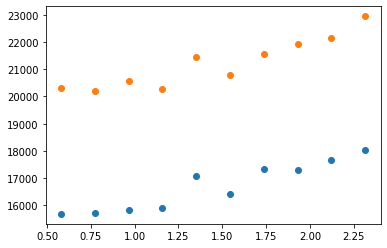

In [394]:
# import matplotlib.pyplot as plt
# import math
# # print(results.xoutput_dict['W0s'])
# W0s=results.xoutput_dict['W0s'].result
# tav=results.xoutput_dict['Tem_av'].result
# sixfs=results.xoutput_dict['r06fs'].result
# twfs=results.xoutput_dict['r012fs'].result
# r246fs=results.xoutput_dict['r24_6fs'].result
# # type(W0s[11])
# # print(len(W1s),len(sixfs))
# # # len
# for i in range(1,len(W0s)-1):
#     W0[i]=W0s[i]/0.001 # [m] to [mm] unit

#     # W1s[i]=math.ceil(W0s[i])

# # print(W1s)
# # W2s=np.array((W1s))
# print(W0s)
 
# print('W0',W0)
# # zero-th wavenumber
# plt.scatter(W0[2:12],sixfs[2:12])
# plt.scatter(W0[2:12],twfs[2:12])


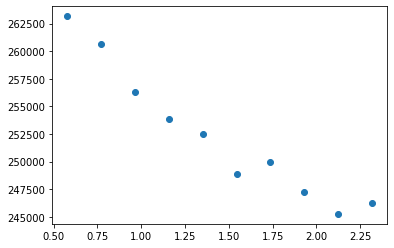

In [392]:
# plt.scatter(W0[2:12],r246fs[2:12])

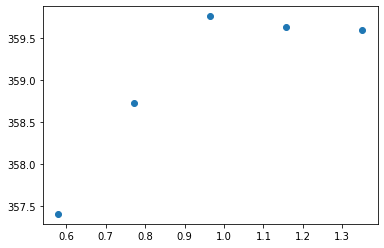

In [393]:
# plt.scatter(W0[2:7],tav[2:7])

ValueError: x and y must be the same size

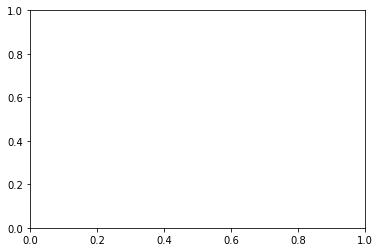

In [395]:
# plt.scatter(tav[2:13],r246fs[2:13])
# plt.scatter(tav[2:13],twfs[2:13])

In [72]:
sweep = VarParam(
    stop_if_error=True,
    is_reuse_femm_file=False,
    is_keep_all_output=True,
)
ref_simu.var_simu = sweep
N_sweep = 14
ref_simu.var_simu.paramexplorer_list = [
    ParamExplorerInterval(
        name="Stator slot opening",
        symbol="W0s",
        unit="m",
        setter="simu.machine.stator.slot.W0",
        getter="simu.machine.stator.slot.W0",
        min_value=0.1 * Toyota_Prius.stator.slot.W0,
        max_value=1.4 * Toyota_Prius.stator.slot.W0,
        N=N_sweep,
    )
]

In [73]:
Xout_sweep = ref_simu.run()

[23:47:59] Starting running simulation test_slot_scale (machine=IPMSM8P48S_1)
[23:47:59] Computing reference simulation for Parameter Sweep
[23:47:59] W0s: 14 values from 0.000193 to 0.002702 (ref=0.00193) [m]
[23:47:59] Starting Magnetic module
[23:48:04] Computing Airgap Flux in FEMM
[23:48:07] Starting Force module
[23:48:07] Parameter Sweep Reference Results: N0=2000 [rpm], Id=-135.4 [Arms], Iq=113.6 [Arms], Tem_av=359.6 [N.m], Tem_rip_pp=83.24 [N.m], Tem_rip_norm=0.2315 [-], Pem_av=7.531e+04 [W]
[===                                               ]   6%
[23:48:07] Running simulation 1/14 with W0s=0.000193
[23:48:07] Starting Magnetic module
[23:48:10] Computing Airgap Flux in FEMM
[23:48:14] Starting Force module
[23:48:14] Parameter Sweep Results: N0=2000 [rpm], Id=-135.4 [Arms], Iq=113.6 [Arms], Tem_av=351.8 [N.m], Tem_rip_pp=92.7 [N.m], Tem_rip_norm=0.2635 [-], Pem_av=7.369e+04 [W]
[======                                            ]  13%
[23:48:14] Running simulation 2/14 with 

In [28]:
Xout_sweep.

[0.193 0.386 0.579 0.772 0.965 1.158 1.351 1.544 1.737 1.93  2.123 2.316
 2.509 2.702]


[351.84337021945214, 354.1277052032797, 355.25543876012574, 356.5752040756719, 357.655724486765, 358.59243114821936, 359.25332958771867, 359.6009065958757, 359.1817823718711, 359.58829519198184, 359.6517054090791, 359.7996157660691, 359.8602357775156, 359.8664669796591]
[0.193 0.386 0.579 0.772 0.965 1.158 1.351 1.544 1.737 1.93  2.123 2.316
 2.509 2.702]
14


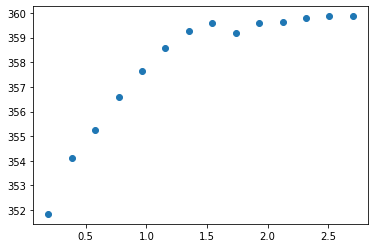

In [29]:
import matplotlib.pyplot as plt
import math

Tem = (Xout_sweep.xoutput_dict["Tem_av"].result)
print(Tem)

W0s_val=Xout_sweep.paramexplorer_list[0].get_value()
W0=np.array((W0s_val))
W0=W0/0.001  # [m] to [mm] unit
print(W0)

# W0s_val = Xout_sweep.paramexplorer_list[0].get_value()
# W0=np.array((W0s_val))
# for i in range(1,len(W0s_val)-1):
#     W0[i]=W0s_val[i]/0.001 

# Xout_sweep
# for i in range(1,N_sweep):
#     Xout_sweep.output_list[i].simu.machine.stator.slot.plot()
    

In [128]:
fr_r0_6fs=[]
ft_r0_6fs=[]
fr_r0_12fs=[]
ft_r0_12fs=[]
fr_r24_6fs=[]
ft_r24_6fs=[]
ft_rn24_6fs=[]

ft_r0_0fs=[]
Torque_map=[]
Torque_rip=[]

for i in range(0, len(Xout_sweep.output_list)):
    fr_r0_6fs=np.append(fr_r0_6fs,Xout_sweep.output_list[i].force.AGSF.components['radial'].get_magnitude_along('freqs->elec_order=6','wavenumber=0')['AGSF_r'])
    fr_r0_12fs=np.append(fr_r0_12fs,Xout_sweep.output_list[i].force.AGSF.components['radial'].get_magnitude_along('freqs->elec_order=12','wavenumber=0')['AGSF_r'])
    fr_r24_6fs=np.append(fr_r24_6fs,Xout_sweep.output_list[i].force.AGSF.components['radial'].get_magnitude_along('freqs->elec_order=6','wavenumber=24')['AGSF_r'])

    ft_r0_0fs=np.append(ft_r0_0fs,Xout_sweep.output_list[i].force.AGSF.components['tangential'].get_magnitude_along('freqs->elec_order=0','wavenumber=0')['AGSF_t'])

    ft_r0_6fs=np.append(ft_r0_6fs,Xout_sweep.output_list[i].force.AGSF.components['tangential'].get_magnitude_along('freqs->elec_order=6','wavenumber=0')['AGSF_t'])
    ft_r0_12fs=np.append(ft_r0_12fs,Xout_sweep.output_list[i].force.AGSF.components['tangential'].get_magnitude_along('freqs->elec_order=12','wavenumber=0')['AGSF_t'])
    ft_r24_6fs=np.append(ft_r24_6fs,Xout_sweep.output_list[i].force.AGSF.components['tangential'].get_magnitude_along('freqs->elec_order=6','wavenumber=24')['AGSF_t'])
    ft_rn24_6fs=np.append(ft_rn24_6fs,Xout_sweep.output_list[i].force.AGSF.components['tangential'].get_magnitude_along('freqs->elec_order=6','wavenumber=-24')['AGSF_t'])
    
    Torque_map=np.append(Torque_map,Xout_sweep.output_list[i].mag.Tem_av)
    Torque_rip=np.append(Torque_rip,Xout_sweep.output_list[i].mag.Tem_rip_norm)
    

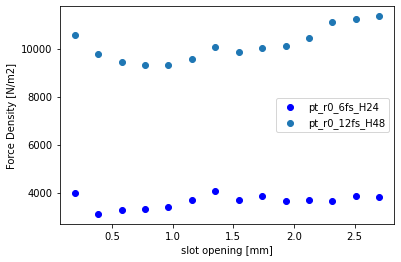

In [123]:
# plt.scatter(W0,fr_r0_6fs,label="pr_r0_6fs_H24",marker='x',color='blue')
# plt.scatter(W0,fr_r0_12fs,label="pr_r0_12fs_H48",marker='x')
plt.scatter(W0,ft_r0_6fs,label="pt_r0_6fs_H24",color='blue')
plt.scatter(W0,ft_r0_12fs,label="pt_r0_12fs_H48")



plt.xlabel('slot opening [mm]')
plt.ylabel('Force Density [N/m2]')
plt.legend()

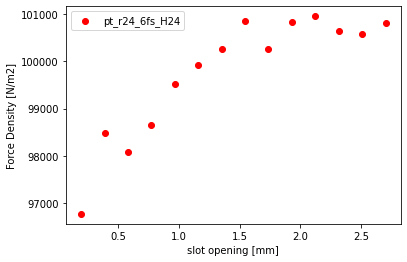

In [130]:
# plt.scatter(W0,fr_r24_6fs,label="pr_r0_6fs_H24",marker='x')
plt.scatter(W0,ft_r24_6fs,label="pt_r24_6fs_H24",color='red')
# plt.scatter(W0,ft_rn24_6fs,label="pt_r-24_6fs_H24",color='orange')
plt.xlabel('slot opening [mm]')
plt.ylabel('Force Density [N/m2]')
plt.legend()

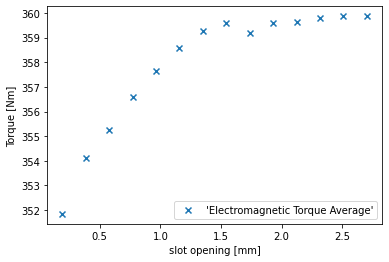

In [96]:
plt.scatter(W0,Torque_map,label="'Electromagnetic Torque Average'",marker='x')
plt.xlabel('slot opening [mm]')
plt.ylabel('Torque [Nm]')
plt.legend()

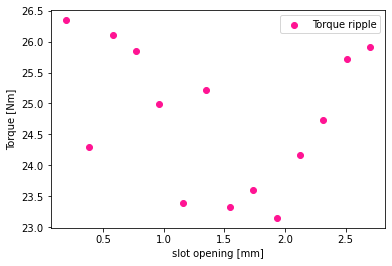

In [97]:
plt.scatter(W0,Torque_rip*100,label='Torque ripple',color='deeppink')
plt.xlabel('slot opening [mm]')
plt.ylabel('Torque [Nm]')
plt.legend()

Text(0, 0.5, 'pt [N/m2]')

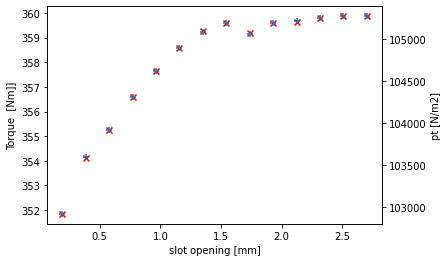

In [113]:
fig, ax1 = plt.subplots()
ax1.scatter(W0,Torque_map,label="'Electromagnetic Torque Average'",marker='x',color='red')
ax2 = ax1.twinx()
ax2.scatter(W0,ft_r0_0fs,label='r0_0fs',marker='+')

ax1.set_xlabel('slot opening [mm]')
ax1.set_ylabel('Torque  [Nm]]')
ax2.set_ylabel('pt [N/m2]')





Text(0, 0.5, 'pt sum [N/m2]')

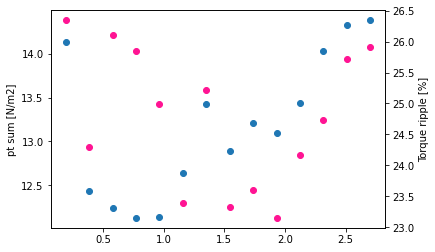

In [101]:


fig, ax1 = plt.subplots()
ax1.scatter(W0,(ft_r0_12fs+ft_r0_6fs)/ft_r0_0fs*100,label="pt_sum")

ax2 = ax1.twinx()
ax2.scatter(W0,Torque_rip*100,label='Torque ripple',color='deeppink')
ax2.set_ylabel('Torque ripple [%]')

ax1.set_label('slot opening [mm]')
ax1.set_ylabel('pt sum [N/m2]')
# ax1.legend()
# ax2.legend()